# Modeling - Housing Price Prediction

## By: Nick Roller

## 1. Problem Statement:

Our client has asked us to produce a model to predict the expected price of a home given it's features, ammenities and attributes. As our dependant variable is continuous (dollar amount of home value) this will be a regression model. We will be exploring the following regression models, applying them to our dataset and determining the one that best suits our client's needs:
- Linear Regression
- Random Forest Regression
- Ridge Regression
- Lasso Regression

In [1]:
#!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from boruta import BorutaPy
from xgboost import XGBClassifier
from xgboost import plot_importance

In [3]:
pd.set_option('display.max_rows', 500)

We first load our preprocessed data. As we can see, we have already one-hot encoded the categorical variables and scaled all continuous ones.

In [4]:
df = pd.read_csv('Data Files/data_preprocessed.csv')
df.head()

,SalePrice,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,208500,65.0,8450,196.0,706,150,856,856,854,1710,...,0,0,0,1,0,0,0,0,1,0
1,181500,80.0,9600,0.0,978,284,1262,1262,0,1262,...,0,0,0,1,0,0,0,0,1,0
2,223500,68.0,11250,162.0,486,434,920,920,866,1786,...,0,0,0,1,0,0,0,0,1,0
3,250000,84.0,14260,350.0,655,490,1145,1145,1053,2198,...,0,0,0,1,0,0,0,0,1,0
4,307000,75.0,10084,186.0,1369,317,1686,1694,0,1694,...,0,0,0,1,0,0,0,0,1,0


## 2. Splitting training and test data

In [5]:
#We first prepare our train and test data sets
y=df['SalePrice'].values
X=df.drop('SalePrice', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

scaler = StandardScaler()
scaler.fit(X_train)
X_tr_scaled = scaler.transform(X_train)
X_te_scaled = scaler.transform(X_test)

In [6]:
X_train.shape, X_test.shape

((909, 250), (228, 250))

In [7]:
y_train.shape, y_test.shape

((909,), (228,))

## 3. Feature Selection

### a. SelectKBest

We will first be utilizing SelectKBest with GridSearchCV to determine the k best features.

#### SelectKBest pipeline

In [8]:
#Set up pipeline with to refine number of features to 10 (default)
pipe = make_pipeline(
    SelectKBest(f_regression),
    LinearRegression()
)

In [9]:
#fitting pipeline to training data
pipe.fit(X_train, y_train)

Pipeline(steps=[('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x000001F6E22E0E50>)),
                ('linearregression', LinearRegression())])

In [10]:
#making predictions on our test data
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [11]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.8322084424795724, 0.8132457332436878)

In [12]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(18527.224700180825, 19577.466764064695)

In [13]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(679290956.2851087, 812174965.7454973)

#### Linear Model with SelectKBest and Gridsearch CV

In [14]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'selectkbest', 'linearregression', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize'])

In [15]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

In [16]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [17]:
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000001F6E22E0E50>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [18]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [19]:
lr_grid_cv.best_params_

{'selectkbest__k': 158}

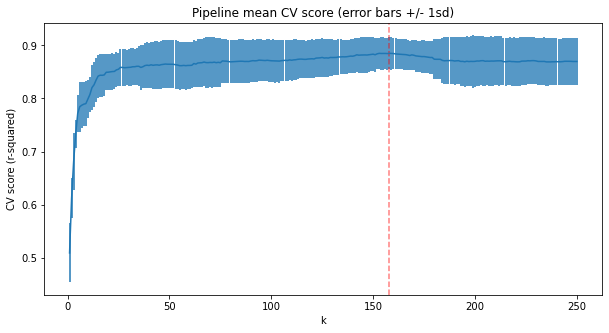

In [20]:
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [21]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

In [22]:
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

SaleType_CWD             46302.717961
Neighborhood_Crawfor     35540.580766
Neighborhood_NridgHt     26525.412118
ExterQual_Ex             26489.107767
Neighborhood_StoneBr     25685.749614
Neighborhood_BrDale      22396.759321
SaleType_New             20985.518168
Neighborhood_NoRidge     19696.901394
KitchenQual_Ex           18260.457787
BsmtExposure_Gd          17524.201533
Neighborhood_Somerst     14808.217544
MasVnrType_Stone         14338.653680
BsmtQual_Ex              13598.380558
Neighborhood_BrkSide     13316.408963
GarageType_CarPort       12879.382114
Functional_Typ           12622.643276
Exterior2nd_Wd Sdng      11736.652409
GarageType_Detchd        11667.066529
Exterior2nd_Other        11652.686712
FireplaceQu_Ex           11315.405938
BldgType_1Fam            11102.948703
LotConfig_CulDSac         9871.414972
GarageType_BuiltIn        9338.789159
GarageType_Attchd         8910.296390
MasVnrType_BrkFace        8577.176341
HouseStyle_1.5Unf         8229.522484
MasVnrType_N

### b. Random Forest Model

#### Make Pipeline

In [23]:
RF_pipe = make_pipeline(
    StandardScaler(),
    RandomForestRegressor()
)

#### Fit and assess using CV

In [24]:
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [25]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.8435435 , 0.89105981, 0.86956449, 0.87071647, 0.90642222])

In [26]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.8762612973912045, 0.021329431393809026)

#### GridsearchCV

In [27]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None]
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None]}

In [28]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [29]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'standardscaler': [StandardScaler(), None]})

In [30]:
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 88, 'standardscaler': StandardScaler()}

In [31]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.8405579 , 0.88505412, 0.8657286 , 0.87592723, 0.90533263])

In [32]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.8745200989332359, 0.021415317571398466)

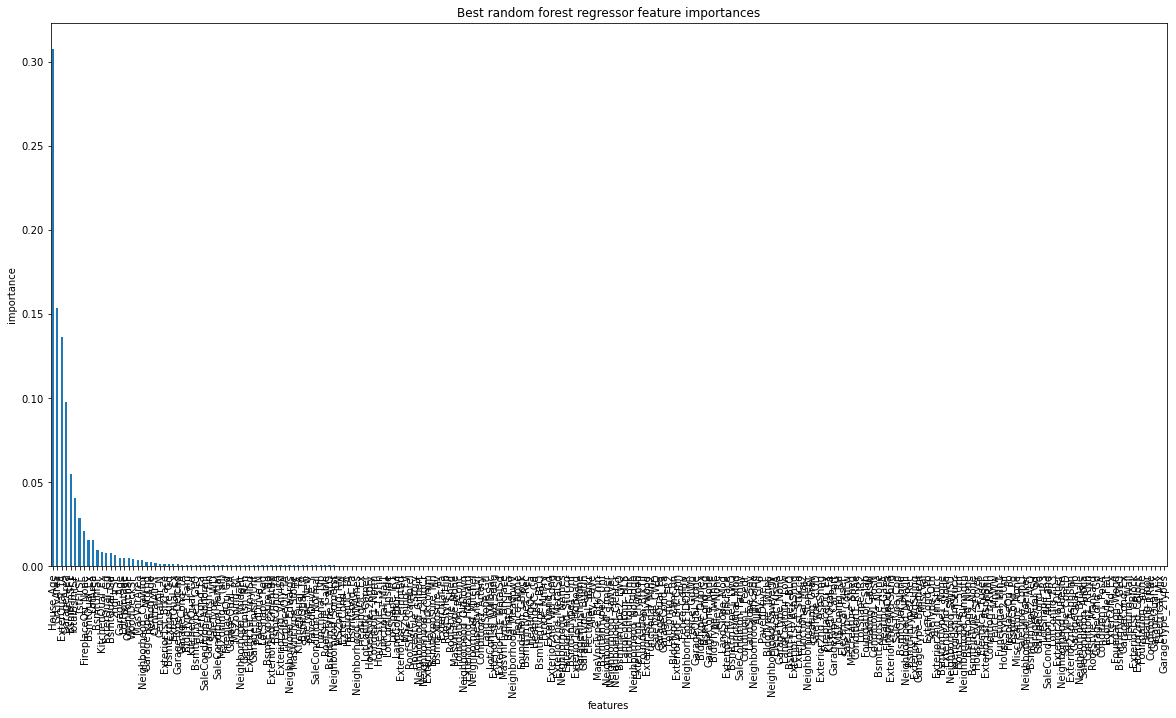

In [33]:
plt.subplots(figsize=(20, 10))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

In [34]:
rf_feat_imps

House_Age                3.077860e-01
GrLivArea                1.533805e-01
ExterQual_TA             1.361417e-01
GarageArea               9.753199e-02
BsmtFinSF1               5.477032e-02
TotalBsmtSF              4.046441e-02
1stFlrSF                 2.892719e-02
FireplaceQu_None         2.084464e-02
BsmtQual_Ex              1.580955e-02
LotArea                  1.539670e-02
BsmtUnfSF                9.463384e-03
KitchenQual_Ex           8.383617e-03
ExterQual_Gd             8.072303e-03
BsmtQual_Gd              7.687859e-03
2ndFlrSF                 6.614621e-03
Garage_Age               5.063185e-03
LotFrontage              5.022479e-03
OpenPorchSF              4.902067e-03
WoodDeckSF               4.540039e-03
MasVnrArea               3.955879e-03
Neighborhood_Crawfor     3.655097e-03
GarageType_Attchd        2.703187e-03
Remod_Age                2.690119e-03
CentralAir_Y             1.864445e-03
CentralAir_N             1.560325e-03
Exterior1st_BrkFace      1.550519e-03
BsmtExposure

### c. XGBoost

In [35]:
from xgboost import XGBRegressor
from xgboost import plot_importance

# fit model to training data
xgb_model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
xgb_model.fit(X_train, y_train)

pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

ExterQual_TA             2.322960e-01
KitchenQual_Ex           1.089326e-01
BsmtQual_Ex              5.585622e-02
ExterQual_Fa             4.845393e-02
House_Age                4.596350e-02
GarageType_2Types        3.788871e-02
Heating_Grav             2.998203e-02
ExterQual_Ex             2.372622e-02
FireplaceQu_None         2.309152e-02
GrLivArea                2.185407e-02
Neighborhood_Crawfor     2.041956e-02
GarageCond_TA            1.957448e-02
ExterCond_Po             1.685602e-02
Exterior1st_BrkComm      1.652418e-02
CentralAir_N             1.439788e-02
MSZoning_C (all)         1.225619e-02
LotShape_IR3             1.006820e-02
Functional_Maj2          9.603544e-03
ExterQual_Gd             7.356325e-03
GarageQual_TA            6.661664e-03
KitchenQual_Gd           6.645750e-03
BldgType_1Fam            6.616582e-03
Functional_Mod           6.352918e-03
GarageArea               6.180365e-03
BsmtFinSF1               5.946617e-03
MSZoning_RL              5.805476e-03
GarageCond_P

<Figure size 7200x21600 with 0 Axes>

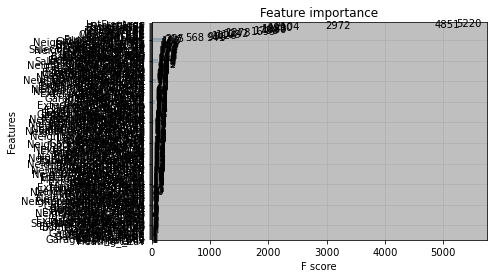

In [36]:
# plot feature importance
plt.figure(figsize=(100,300))
plot_importance(xgb_model)
plt.show()

### d. Bortua

Finally we will try Bortua for feature selection and see if there are any features that consistently appear in the top performers across all methods we've tried so far.

In [37]:
rcf = RandomForestRegressor()
rcf.fit(X_train, y_train)

base_score = rcf.score(X_test, y_test)

In [39]:
boruta_selector = BorutaPy(rcf, n_estimators='auto', verbose = 2)

X_train_boruta=X_train
y_train_boruta=y_train
boruta_selector.fit(np.array(X_train_boruta), np.array(y_train_boruta))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	250
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	250
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	250
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	250
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	250
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	250
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	250
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	20
Rejected: 	230
Iteration: 	9 / 100
Confirmed: 	13
Tentative: 	7
Rejected: 	230
Iteration: 	10 / 100
Confirmed: 	13
Tentative: 	7
Rejected: 	230
Iteration: 	11 / 100
Confirmed: 	13
Tentative: 	7
Rejected: 	230
Iteration: 	12 / 100
Confirmed: 	13
Tentative: 	7
Rejected: 	230
Iteration: 	13 / 100
Confirmed: 	13
Tentative: 	7
Rejected: 	230
Iteration: 	14 / 100
Confirmed: 	13
Tentative: 	7
Rejected: 	230
Iteration: 	15 / 100
Confirmed: 	13
Tentative: 	7
Rejected: 	230
Iteration: 	16 / 100
Confirmed: 	13
Tenta

BorutaPy(estimator=RandomForestRegressor(n_estimators=58,
                                         random_state=RandomState(MT19937) at 0x1F6DDE73B40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1F6DDE73B40, verbose=2)

In [41]:
pd.Series(boruta_selector.ranking_, index=X_train.columns).sort_values(ascending=True)

GrLivArea                  1
BsmtQual_Gd                1
House_Age                  1
BsmtQual_Ex                1
GarageArea                 1
KitchenQual_Ex             1
2ndFlrSF                   1
FireplaceQu_None           1
TotalBsmtSF                1
BsmtUnfSF                  1
BsmtFinSF1                 1
ExterQual_TA               1
LotArea                    1
1stFlrSF                   1
OpenPorchSF                2
Garage_Age                 2
WoodDeckSF                 4
Neighborhood_Crawfor       4
LotFrontage                5
ExterQual_Gd               6
MasVnrArea                 7
CentralAir_N               8
CentralAir_Y               9
GarageType_Detchd         10
ExterQual_Ex              12
Remod_Age                 12
GarageType_Attchd         13
BldgType_1Fam             14
BsmtFinType1_GLQ          15
GarageQual_TA             17
KitchenQual_Gd            17
Neighborhood_NridgHt      18
GarageCond_TA             19
ExterCond_Fa              20
MSZoning_RL   

In [42]:
X_train = boruta_selector.transform(np.array(X_train))
X_test = boruta_selector.transform(np.array(X_test))

rcf = XGBRegressor()
rcf.fit(X_train, y_train)

new_score = rcf.score(X_test, y_test)

change = (new_score -base_score)*100/base_score
print(f'Your model accuracy has been affect by {change} percent')

Your model accuracy has been affect by -6.05047793165352 percent


#### Based on our feature selection models, we compared the features that consistently appeared in the top 20 in terms of feature importance. The final 10 features we have selected to use in our model moving forward are as follows:
- GrLiveArea
- House_Age
- Garage_Age
- TotalBsmtSF
- LotArea
- ExterQual_TA
- BsmtQual_Ex
- KitchenQual_Ex
- OpenPorchSF
- FirepalceQu_None

Some features were left out due to redundancy, such as 1st and 2nd floor square footage, because GrLiveArea encompasses both of these. Also it is interesting to note that whether or not the house has a fireplace is more important than the quality, makes sense, and that excellent quality kitchens and basements is more important than exterior quality. 

In [48]:
#Recreate our dataframe using only the selected features and re-split into train and test sets
df = df[['SalePrice','GrLivArea','House_Age','Garage_Age','TotalBsmtSF','LotArea','ExterQual_TA','BsmtQual_Ex','KitchenQual_Ex','OpenPorchSF','FireplaceQu_None']]
df.head()

,SalePrice,GrLivArea,House_Age,Garage_Age,TotalBsmtSF,LotArea,ExterQual_TA,BsmtQual_Ex,KitchenQual_Ex,OpenPorchSF,FireplaceQu_None
0,208500,1710,18,18.0,856,8450,0,0,0,61,1
1,181500,1262,45,45.0,1262,9600,1,0,0,0,0
2,223500,1786,20,20.0,920,11250,0,0,0,42,0
3,250000,2198,21,21.0,1145,14260,0,0,0,84,0
4,307000,1694,17,17.0,1686,10084,0,1,0,57,0


In [49]:
y=df['SalePrice'].values
X=df.drop('SalePrice', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [50]:
#verify their new shapes
X_train.shape, X_test.shape

((909, 10), (228, 10))

In [51]:
y_train.shape, y_test.shape

((909,), (228,))

## 3. Model Selection

### A. Evaluate performance of the mean

#### We will first evaluate how well simply taking the mean does in predicting home value, this will give us a baseline to compare our models against.

In [52]:
train_mean = y_train.mean()
train_mean

169478.5599559956

In [53]:
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[169478.559956]])

In [54]:
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([169478.559956, 169478.559956, 169478.559956, 169478.559956,
       169478.559956])

In [55]:
r2_score(y_train, y_tr_pred)

0.0

In [56]:
y_te_pred = train_mean * np.ones(len(y_test))
r2_score(y_test, y_te_pred)

-1.4589143687571138e-05

In [57]:
dumb_reg.predict(X_test)

array([169478.559956, 169478.559956, 169478.559956, 169478.559956,
       169478.559956, 169478.559956, 169478.559956, 169478.559956,
       169478.559956, 169478.559956, 169478.559956, 169478.559956,
       169478.559956, 169478.559956, 169478.559956, 169478.559956,
       169478.559956, 169478.559956, 169478.559956, 169478.559956,
       169478.559956, 169478.559956, 169478.559956, 169478.559956,
       169478.559956, 169478.559956, 169478.559956, 169478.559956,
       169478.559956, 169478.559956, 169478.559956, 169478.559956,
       169478.559956, 169478.559956, 169478.559956, 169478.559956,
       169478.559956, 169478.559956, 169478.559956, 169478.559956,
       169478.559956, 169478.559956, 169478.559956, 169478.559956,
       169478.559956, 169478.559956, 169478.559956, 169478.559956,
       169478.559956, 169478.559956, 169478.559956, 169478.559956,
       169478.559956, 169478.559956, 169478.559956, 169478.559956,
       169478.559956, 169478.559956, 169478.559956, 169478.559

##### R^2

In [58]:
r_mean = dumb_reg.score(X_test, y_test)
print(r_mean)

-1.4589143687571138e-05


##### MAE

In [59]:
#MAE for dummy regression mean model
mae_mean = mean_absolute_error(y_test, y_te_pred)
mae_mean

45471.53701291182

##### MSE

In [60]:
#MSE for dummy regression mean model
mse_mean = mean_squared_error(y_test, y_te_pred)
mse_mean

3608816328.6971273

### B. Linear Regression Model

In [61]:
#fit linear regression model and make prediction
reg = LinearRegression()
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)

In [62]:
#Print R^2
r2_score(y_test, y_pred)

0.7849018954588608

In [107]:
lr_mae = mean_absolute_error(y_test, y_pred)
lr_mae

19779.89965087796

In [108]:
lr_mse = mean_squared_error(y_test, y_pred)
lr_mse

776238227.2888312

In [109]:
(mae_mean-lr_mae)/mae_mean

0.5650048150942999

In [110]:
(mse_mean-lr_mse)/mse_mean

0.7849050335102333

Applying the basic lienar regression model has improved the prediction performance fairly significantly, MAE by 57% and MSE by 75% as we can see here.

#### Cross-Validation of linear model

In [67]:
#Importing CV score module and computing 5 fold scores

cv_scores = cross_val_score(reg, X, y, cv=5)

In [68]:
#Printing CV scores and their mean
print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[0.82343818 0.8484645  0.8307415  0.83775143 0.81907739]
Average 5-Fold CV Score: 0.831894597205627


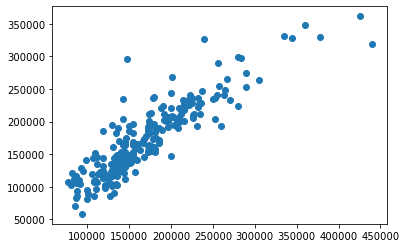

In [69]:
plt.scatter(y_test, y_pred)

### C. Random Forest Model

#### Make Pipeline

In [70]:
RF_pipe = make_pipeline(
    StandardScaler(),
    RandomForestRegressor()
)

#### Fit and assess using CV

In [71]:
rf_default_cv_results = cross_validate(RF_pipe, X_train, y_train, cv=5)

In [83]:
rf_cv_scores = rf_default_cv_results['test_score']
rf_cv_scores

array([0.853257  , 0.82382133, 0.84610147, 0.86693318, 0.87351366])

In [84]:
np.mean(rf_cv_scores)

0.8527253280401729

In [73]:
np.mean(rf_cv_scores), np.std(rf_cv_scores)

(0.8527253280401729, 0.017398948871150642)

#### GridsearchCV

In [74]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None]
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None]}

In [75]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [76]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'standardscaler': [StandardScaler(), None]})

In [77]:
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 1000, 'standardscaler': None}

In [78]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.85488801, 0.8347132 , 0.84605049, 0.87032726, 0.87438075])

In [79]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.8560719412423354, 0.014808466104776567)

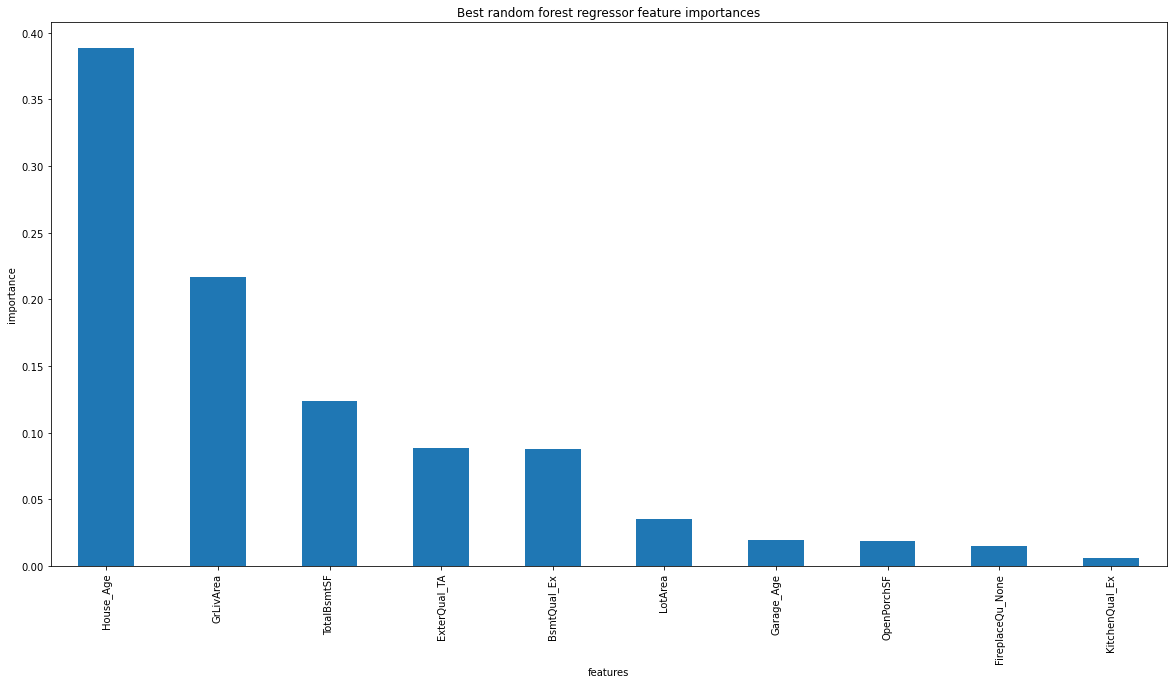

In [80]:
plt.subplots(figsize=(20, 10))
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

In [81]:
rf_feat_imps

House_Age           0.388429
GrLivArea           0.216916
TotalBsmtSF         0.123833
ExterQual_TA        0.088364
BsmtQual_Ex         0.087556
LotArea             0.035575
Garage_Age          0.019314
OpenPorchSF         0.018611
FireplaceQu_None    0.015249
KitchenQual_Ex      0.006153
dtype: float64

### 3. Lasso Regression Model

In [85]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.4, normalize=True)
lasso.fit(X_train,y_train)

Lasso(alpha=0.4, normalize=True)

In [86]:
df_vars=df.drop('SalePrice',axis=1)
colnames = df_vars.columns

In [87]:
lasso_coef = lasso.coef_
pd.Series(lasso_coef, index=colnames).sort_values(ascending=False)

BsmtQual_Ex         46204.917960
KitchenQual_Ex      31976.387338
Garage_Age             83.093401
OpenPorchSF            55.219464
GrLivArea              53.919401
TotalBsmtSF            32.617751
LotArea                 1.528300
House_Age            -563.457039
FireplaceQu_None    -9952.065414
ExterQual_TA       -22511.217360
dtype: float64

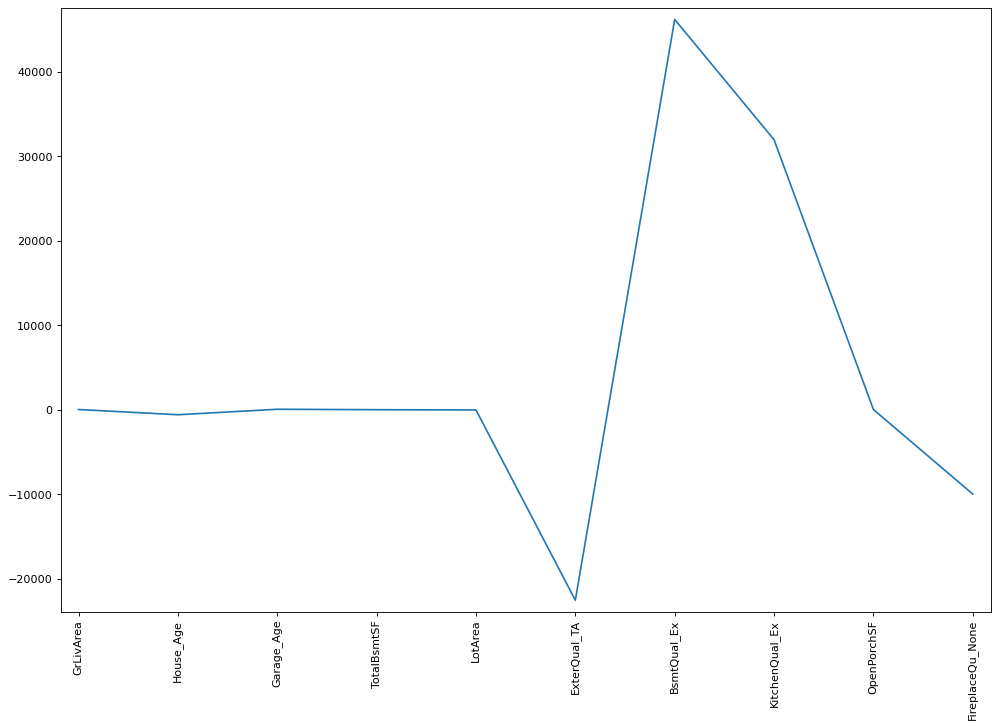

In [88]:
# Plot the coefficients
from matplotlib.pyplot import figure
figure(figsize=(15, 10), dpi=80)
plt.plot(range(len(colnames)), lasso_coef)
plt.xticks(range(len(colnames)), colnames.values, rotation=90) 
plt.margins(0.02)
plt.show()

### 4. Ridge Regression Model

In [89]:
from sklearn.linear_model import Ridge

alpha_space = np.logspace(-4, 0, 50)
ridge_scores = []
ridge_scores_std = []

ridge = Ridge(normalize=True)

In [90]:
for alpha in alpha_space:
    ridge.alpha = alpha
    ridge_cv_scores = cross_val_score(ridge, X, y, cv=10)
    ridge_scores.append(np.mean(ridge_cv_scores))
    ridge_scores_std.append(np.std(ridge_cv_scores))

In [91]:
def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()


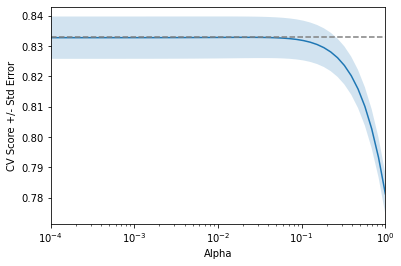

In [92]:
display_plot(ridge_scores, ridge_scores_std)

## 4. Model Performance

### Linear Regression Model

In [111]:
lr_neg_mae = cross_validate(reg, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [112]:
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
lr_mae_mean, lr_mae_std

(18615.55148556662, 641.6818027838742)

In [114]:
mean_absolute_error(y_test, reg.predict(X_test))

19779.89965087796

### Random Forest Model

In [97]:
rf_neg_mae = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [98]:
rf_mae_mean = np.mean(-1 * rf_neg_mae['test_score'])
rf_mae_std = np.std(-1 * rf_neg_mae['test_score'])
rf_mae_mean, rf_mae_std

(17088.659006317233, 1032.0095554079535)

In [99]:
mean_absolute_error(y_test, rf_grid_cv.best_estimator_.predict(X_test))

17557.124758472568

### Lasso Regression Model

In [115]:
lasso_neg_mae = cross_validate(lasso, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [116]:
lasso_mae_mean = np.mean(-1 * lasso_neg_mae['test_score'])
lasso_mae_std = np.std(-1 * lasso_neg_mae['test_score'])
lasso_mae_mean, lasso_mae_std

(18614.602823577286, 641.5269406724203)

In [117]:
mean_absolute_error(y_test, lasso.predict(X_test))

19775.27503103904

### Ridge Regression Model

In [125]:
ridge_neg_mae = cross_validate(ridge, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
ridge.fit(X_train, y_train)

Ridge(normalize=True)

In [126]:
ridge_mae_mean = np.mean(-1 * ridge_neg_mae['test_score'])
ridge_mae_std = np.std(-1 * ridge_neg_mae['test_score'])
ridge_mae_mean, ridge_mae_std

(21184.959698873583, 899.3041482899164)

In [127]:
mean_absolute_error(y_test, ridge.predict(X_test))

20592.10792082996

## Conclusion

After having narrowed down our features to the top 10 in terms of feature importance, we then ran four different regression models to determine which was best for predicting a home's sale price. We ran a basic linear regression model in addition to random forest, lasso and ridge regression models. After using these models to predict on our test set with 5 fold cross validation, we have determined the Forest Regression model to be the preferred and best performing model. 